In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
from env import github_token, github_username

import prepare
import acquire
import explore
from explore import percentage_stacked_plot
#import model
from acquire import scrape_github_data
from acquire import get_github_data
import unicodedata
import re
import json
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = get_github_data()

In [3]:
# prepare the data by creating clean, stemmed and lemmatized columns
df = prepare.prep_github_data(df, column='readme_contents')


In [4]:
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,jagrosh/MusicBot,Java,"<img align=""right"" src=""https://i.imgur.com/zr...",img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...
1,Just-Some-Bots/MusicBot,Python,# MusicBot\n\n[![GitHub stars](https://img.shi...,music github starshttpsimgshieldsiogithubstars...,music github starshttpsimgshieldsiogithubstars...,music github starshttpsimgshieldsiogithubstars...
2,SudhanPlayz/Discord-MusicBot,JavaScript,"<h1 align=""center""><img src=""./assets/logo.gif...",h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...
3,IVETRI/SongPlayRoBot,Python,# Check Our New Bot Repo & Video :\n\n[Video](...,check new repo video videohttpsyoutube3pn0w4k...,check new repo video videohttpsyoutube3pn0w4kz...,check new repo video videohttpsyoutube3pn0w4kz...
5,galnir/Master-Bot,TypeScript,# A Discord Music Bot written in TypeScript Sa...,discord music written typescript sapphire dis...,discord music written typescript sapphir disco...,discord music written typescript sapphire disc...
...,...,...,...,...,...,...
192,Micium-Development/Bounce,JavaScript,### 📥 Micium-Development Is recruiting develop...,miciumdevelopment recruiting developers want j...,miciumdevelop recruit develop want join dev te...,miciumdevelopment recruiting developer want jo...
193,philliphqs/hqs.bot,Python,"<br />\n<p align=""center"">\n <a href=""https:/...",br p aligncenter hrefhttpsgithubcomphilliphqsh...,br p aligncent hrefhttpsgithubcomphilliphqshqs...,br p aligncenter hrefhttpsgithubcomphilliphqsh...
196,MrRizoel/RiZoeLXMusic,Python,"<h2 align=""centre"">ℝ𝚒ℤ𝚘𝚎𝕃𝕏𝕄𝚞𝚜𝚒𝚌 🎵</h2>\n\n### ...",h2 aligncentrerizoelxmusic h2 play music tele...,h2 aligncentrerizoelxmus h2 play music telegra...,h2 aligncentrerizoelxmusic h2 play music teleg...
197,noirscape/MusicBot-2,Python,# Dynamic cog bot template\n\nThis is a bot te...,dynamic cog template template discordpy fram...,dynam cog templat templat discordpi framework ...,dynamic cog template template discordpy framew...


In [5]:
# Feature Engineer README length
# Get the length of text in each README
df['text_length'] = df.lemmatized.apply(len)
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,text_length
0,jagrosh/MusicBot,Java,"<img align=""right"" src=""https://i.imgur.com/zr...",img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...,2603
1,Just-Some-Bots/MusicBot,Python,# MusicBot\n\n[![GitHub stars](https://img.shi...,music github starshttpsimgshieldsiogithubstars...,music github starshttpsimgshieldsiogithubstars...,music github starshttpsimgshieldsiogithubstars...,1375
2,SudhanPlayz/Discord-MusicBot,JavaScript,"<h1 align=""center""><img src=""./assets/logo.gif...",h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...,2109
3,IVETRI/SongPlayRoBot,Python,# Check Our New Bot Repo & Video :\n\n[Video](...,check new repo video videohttpsyoutube3pn0w4k...,check new repo video videohttpsyoutube3pn0w4kz...,check new repo video videohttpsyoutube3pn0w4kz...,568
5,galnir/Master-Bot,TypeScript,# A Discord Music Bot written in TypeScript Sa...,discord music written typescript sapphire dis...,discord music written typescript sapphir disco...,discord music written typescript sapphire disc...,8350


## Exploration

# Explore and visualize the natural language data that you have acquired. Here are some ideas for exploration:

> - What are the most common words in READMEs?
> - Does the length of the README vary by programming language?
> - Do different programming languages use a different number of unique words?
> - Are there any words that uniquely identify a programming language?


In [6]:
train, test = prepare.split_github_data(df)

train---> (128, 7)
test---> (32, 7)


In [7]:
# counts most frequent words from sentences in a df

top_20_words_readme = Counter(" ".join(train["lemmatized"]).split()).most_common(20)
top_20_words_readme


[('music', 476),
 ('song', 216),
 ('command', 175),
 ('play', 175),
 ('discord', 163),
 ('text', 157),
 ('option', 152),
 ('spotify', 133),
 ('youtube', 132),
 ('help', 129),
 ('file', 129),
 ('default', 108),
 ('support', 106),
 ('run', 105),
 ('token', 100),
 ('install', 100),
 ('queue', 95),
 ('playlist', 90),
 ('img', 86),
 ('show', 86)]

In [8]:
js_words = ' '.join(train[train.language=='JavaScript'].lemmatized)
python_words = ' '.join(train[train.language=='Python'].lemmatized)
j_words = ' '.join(train[train.language=='Java'].lemmatized)
ts_words = ' '.join(train[train.language=='TypeScript'].lemmatized)
go_words = ' '.join(train[train.language=='Go'].lemmatized)
kotlin_words = ' '.join(train[train.language=='Kotlin'].lemmatized)

js_words = re.sub(r'\s.\s', '', js_words)
python_words = re.sub(r'\s.\s', '', python_words)
j_words = re.sub(r'\s.\s', '', j_words)
ts_words = re.sub(r'\s.\s', '', ts_words)
go_words = re.sub(r'\s.\s', '', go_words)
kotlin_words = re.sub(r'\s.\s', '', kotlin_words)



In [9]:
js_words

'discordjs v13 slash command music h3discord httpsdiscordggfy4wmsthrzh3 h3youtube httpsbitly3zgizyrh3 hr h3 discord developer httpsdiscorddevbr discord permission httpsbitly3l4rzpibr download visual studio code httpscodevisualstudiocomdownloadbr download nodejs v16 httpsnodejsorgbr mongodb httpsmongodbcom h3 discordmusictemplate playteddypicker1jhttpswwwarknightskr httpsbluearchivenexoncomhome discordjshttpsdiscordjsorg youtubedlhttpsyoutubedlorg youtubedl rhythm hydra chip discordjs voice builder rest opushttpsgithubcomdiscordjsdiscordjs ffmpeghttpsgithubcomffmpegffmpeg nodeytdlcorehttpsgithubcomfentnodeytdlcore nodeytsrhttpsgithubcomtimeforaninjanodeytsr nodeytplhttpsgithubcomtimeforaninjanodeytpl playdlhttpsgithubcomplaydlplaydl scdlhttpsgithubcomzackradisicnodesoundclouddownloader snowsanthttpsmediadiscordappnetattachments91701405261248103495771418787279678220220328_035332png 100 100 arishttpsmediadiscordappnetattachments91701405261248103495771418808669393820220328_035345png 250 25

In [10]:
# returns the frequency of top words by each language

js_freq = pd.Series(js_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
j_freq = pd.Series(j_words.split()).value_counts()
ts_freq = pd.Series(ts_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
kotlin_freq = pd.Series(kotlin_words.split()).value_counts()

js_freq.head()

music      85
discord    66
song       60
command    57
play       48
dtype: int64

In [11]:
word_counts = (pd.concat([js_freq, python_freq, j_freq, ts_freq, go_freq, kotlin_freq], axis=1, sort=True)
               .set_axis(['JavaScript', 'Python', 'Java', 'TypeScript', 'Go', 'Kotlin'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts['all'] = word_counts['JavaScript'] + word_counts['Python'] + word_counts['Java'] + word_counts['TypeScript'] + word_counts['Go'] + word_counts['Kotlin']
word_counts.sort_values(by="all", ascending = False).head(20)

,JavaScript,Python,Java,TypeScript,Go,Kotlin,all
music,85,313,21,21,16,10,466
song,60,115,7,10,8,12,212
play,48,84,3,7,19,9,170
command,57,59,13,19,11,11,170
text,7,139,5,1,1,1,154
discord,66,35,26,20,5,2,154
option,5,132,0,0,3,1,141
spotify,4,101,1,3,6,16,131
youtube,35,50,17,7,11,9,129
file,22,81,8,8,6,2,127


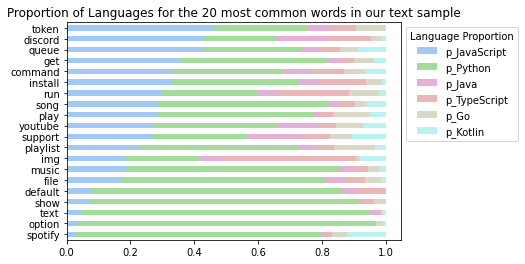

In [14]:
# visualize the percentage of the terms
colors = sns.color_palette("pastel")
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)
(word_counts.assign(p_JavaScript = word_counts.JavaScript/word_counts['all'], 
                   p_Python = word_counts.Python/word_counts['all'],
                    p_Java = word_counts.Java/word_counts['all'],
                    p_TypeScript = word_counts.TypeScript/word_counts['all'],
                    p_Go = word_counts.Go/word_counts['all'],
                    p_Kotlin = word_counts.Kotlin/word_counts['all'])
 .sort_values(by='all')[['p_JavaScript', 'p_Python', 'p_Java', 'p_TypeScript', 'p_Go', 'p_Kotlin']]
 .tail(20)
 .sort_values('p_JavaScript')
 .plot.barh(stacked=True, colormap=cmap1)
            #=['#BBE5ED','#BFBCCB','#B3AA92','#7FD189','#FFF1D6','#A5A5A5'])
)

plt.title("Proportion of Languages for the 20 most common words in our text sample")
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Language Proportion')


<function explore.percentage_stacked_plot(columns_to_plot, title, df)>

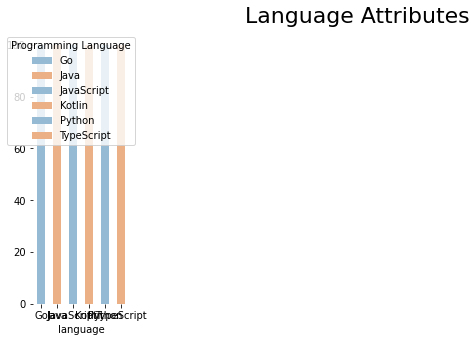

In [15]:
# language attributes
services_columns = ['language']

# stacked plot of programming languages
percentage_stacked_plot(services_columns, 'Language Attributes', train)



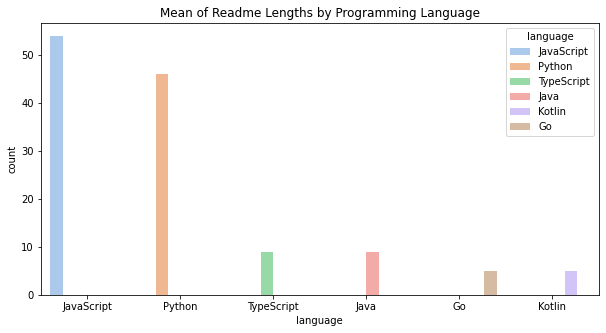

In [16]:
for i, predictor in enumerate(train.drop(columns=['lemmatized','stemmed','clean',
                                                  'readme_contents','repo','text_length'])):
    #plt.figure(i)
    ax = plt.subplots(figsize=(10, 5))
    plt.title("Mean of Readme Lengths by Programming Language")
    hue_order = ['JavaScript', 'Python', 'TypeScript', 'Java', 'Kotlin', 'Go']
    sns.countplot(data=train, x=predictor, hue='language', palette="pastel", hue_order=hue_order, 
              order = train['language'].value_counts().index)
#ax = plt.subplots(figsize=(15, 5))    

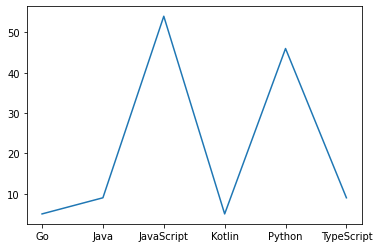

In [17]:
plt.plot(train['language'].value_counts().sort_index())

In [18]:
summary = (
    train
    .groupby('language')
    .filter(lambda x : len(x) > 1)
    .groupby(['language'])
    .size()
    .to_frame(' count')
    .reset_index()
)

summary

,language,count
0,Go,5
1,Java,9
2,JavaScript,54
3,Kotlin,5
4,Python,46
5,TypeScript,9


In [19]:
summary.dtypes

language    object
 count       int64
dtype: object

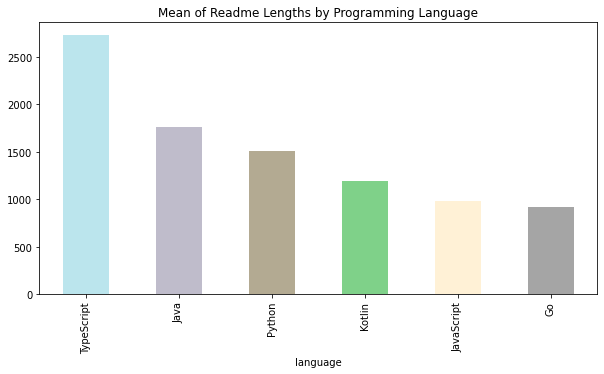

In [22]:
#plots the mean of Readme lengths by programming language

df.groupby(['language']).text_length.mean().sort_values(ascending = False).plot.bar(
                                                                                    color=['#BBE5ED','#BFBCCB',
                                                                                    '#B3AA92','#7FD189',
                                                                                    '#FFF1D6','#A5A5A5'])

#inputs the chart title
plt.title("Mean of Readme Lengths by Programming Language")
#sets the size of the chart
plt.rcParams["figure.figsize"] = (10, 5)

<hr style="border-top: 10px groove red; margin-top: 1px; margin-bottom: 1px"></hr>